# Pseudo GT for SDSSD
- 픽셀 별 Segmentation Score가 특정 Threshold 이상이면 1 아니면 0
- 작은 사람은 Segmentation Score가 낮기 때문에 더 낮은 Threshold 사용
    - Box Height 기준으로 나누기
- 밤에는 Segmentation이 잘 이루어지지 않을 수 있으므로 Thermal Image도 이용하는 것 고려
    - Thermal Image 도 이용할 경우: 1Channel 로 받아서 mean, std (pretrained 모델을 위한) 각각 평균으로 Normalize, Tensor 로 변환 후 Broadcasting 으로 3채널의 Color Image와 더하여 사용
    - 두 이미지를 더해서 사용할 경우: Color, Thermal Image 각각 밤, 낮에 잘 안 보이는 경향이 있기 때문에 밤, 낮에 따라 두 이미지를 1:1 로 더하지 말고 특정 비율을 찾아주자

In [ ]:
from torchvision.models.segmentation import deeplabv3_resnet101
from torchvision import transforms
import torch

from PIL import Image
import os
from tqdm.auto import tqdm
import json
import pickle

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using <{device}> device")

################################
# thermal image 도 이용할 경우
# 이는 1채널로 받아서 mean, std 각각의 평균으로 Normalize
# Tensor로 변환 후 Broadcasting 으로 3채널의 칼라 이미지와 더해준다
################################

mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

to_pil_image = transforms.ToPILImage()

Using <cpu> device


In [ ]:
person_cls_idx = 15
score_threshold = 0.5

data_dir = '/content/drive/MyDrive/2021.summer_URP/PD/KAIST_PD'
ann_dir = '/content/drive/MyDrive/2021.summer_URP/PD/KAIST_PD_SEG'

In [ ]:
img_ids_txt = 'train-all-20.txt'
with open(os.path.join(data_dir, img_ids_txt), 'r') as f:
    img_ids = f.readlines()
img_ids = list(map(lambda x: x[:-1], img_ids))

ann_paths = list(map(
    lambda img_id: os.path.join('annotation_json', img_id+'.json'),
    img_ids
))
img_dir_names = list(map(
    lambda img_id: os.path.split(img_id),
    img_ids
))
color_img_paths = list(map(
    lambda img_dir_name: os.path.join(
        'images', img_dir_name[0], 'visible', img_dir_name[1]+'.jpg'), 
    img_dir_names 
))
thermal_img_paths = list(map(
    lambda img_dir_name: os.path.join(
        'images', img_dir_name[0], 'lwir', img_dir_name[1]+'.jpg'), 
    img_dir_names
))

In [ ]:
gt_save_dir = os.path.split(ann_dir)[0]
gt_save_path = os.path.join(gt_save_dir, 'TRAIN_GT.pkl')

# ====== annotation list 생성 (처음에만 호출) ====== #
# anns = []
# for i, ann_path in tqdm(enumerate(ann_paths)):
#     with open(os.path.join(data_dir, ann_path), 'r') as j:
#         anns_in_img = json.load(j)
#     anns.append(anns_in_img['annotation'])

# with open(gt_save_path, 'wb') as pkl:
#     pickle.dump(anns, pkl)
# ============================================= #

with open(gt_save_path, 'rb') as pkl:
    anns = pickle.load(pkl)

In [ ]:
model = deeplabv3_resnet101(pretrained=True).to(device).eval()

Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth


------

In [ ]:
anns[0:3]

[[{'bbox': [192, 214, 212, 257],
   'category_id': 1,
   'id': 0,
   'image_id': 1217,
   'is_crowd': 0},
  {'bbox': [208, 215, 230, 260],
   'category_id': 1,
   'id': 1,
   'image_id': 1217,
   'is_crowd': 0}],
 [{'bbox': [188, 213, 208, 258],
   'category_id': 1,
   'id': 0,
   'image_id': 1219,
   'is_crowd': 0},
  {'bbox': [203, 215, 225, 261],
   'category_id': 1,
   'id': 1,
   'image_id': 1219,
   'is_crowd': 0}],
 [{'bbox': [183, 213, 203, 260],
   'category_id': 1,
   'id': 0,
   'image_id': 1221,
   'is_crowd': 0},
  {'bbox': [199, 214, 222, 262],
   'category_id': 1,
   'id': 1,
   'image_id': 1221,
   'is_crowd': 0}]]

In [ ]:
num_img = len(color_img_paths)

color_frame_list = []
thermal_frame_list = []
for i in tqdm(range(num_img)):
    with open(os.path.join(data_dir, ann_paths[i]), 'r') as j:
        anns = json.load(j)
    img_id = img_ids[i]

    color_image = Image.open(os.path.join(data_dir, color_img_paths[i]))
    color_image = draw_box(color_image, img_id, anns)
    color_frame_list.append(cv2.cvtColor(np.array(color_image),
                                         cv2.COLOR_BGR2RGB))

    thermal_image = Image.open(os.path.join(data_dir, thermal_img_paths[i]))
    thermal_image = draw_box(thermal_image, img_id, anns)
    thermal_frame_list.append(cv2.cvtColor(np.array(thermal_image),
                                           cv2.COLOR_BGR2RGB))

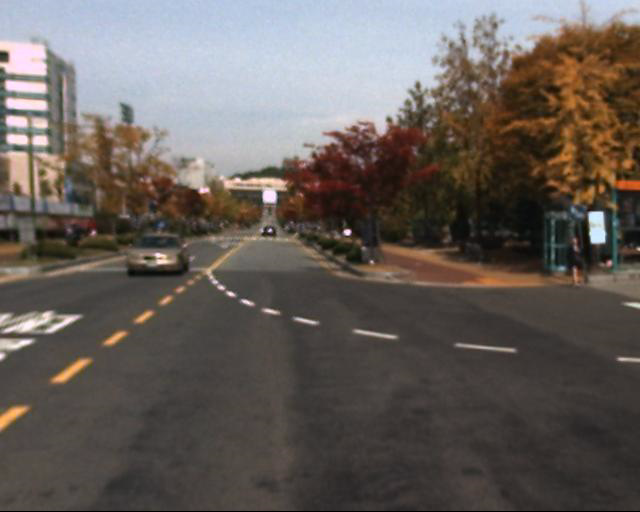

In [ ]:
image = Image.open('/content/drive/MyDrive/2021.summer_URP/PD/KAIST_PD/images/set06/V000/visible/I00059.jpg')
image

In [ ]:
input = preprocess(image).unsqueeze(0).to(device)
output = model(input)['out']

In [ ]:
output = torch.nn.functional.softmax(output, dim=1)

In [ ]:
output = output[:, person_cls_idx, :, :]

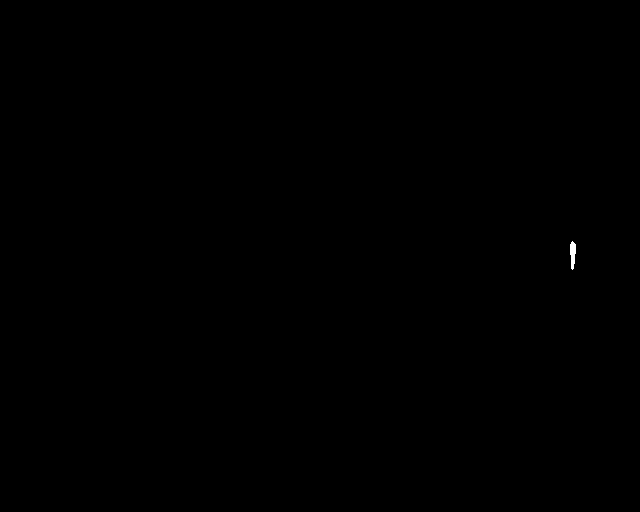

In [ ]:
to_pil_image((output > 0.5).float())